<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/2024_05_03_Custom_Vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 750.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    

In [2]:
import tensorflow as tf

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pathlib

In [6]:
print(keras.__version__)

3.4.1


# loading data set

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [9]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train')

In [10]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    shuffle=True,
    batch_size=32,
    image_size=(224, 224),
    )

Found 7326 files belonging to 4 classes.
Using 5129 files for training.
Using 2197 files for validation.


In [11]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape)  # Should be (32, 224, 224, 3) if batch size is 32
    print(labels.shape)

(32, 224, 224, 3)
(32,)


In [12]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

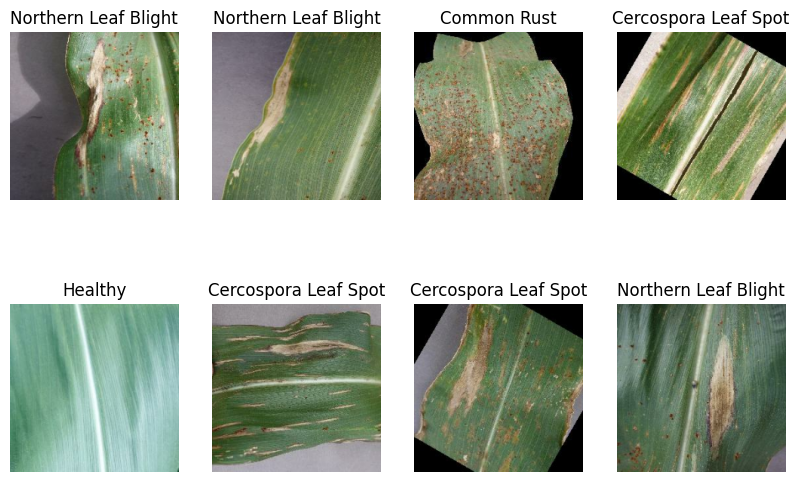

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 69


In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 34


# Configure the hyperparameters

In [18]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 16  #8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [19]:
num_classes = len(class_names)
num_classes

4

# data augmentation

In [20]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
input_shape = train_ds.element_spec[0].shape[1:]  # Shape of the image tensor
input_shape

TensorShape([224, 224, 3])

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

input_shape = train_ds.element_spec[0].shape[1:]  # Shape of the image tensor

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(tf.data.Dataset.from_tensor_slices(tf.zeros(input_shape)))

# multilayer perceptron (MLP)

In [23]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# patch creation as a layer

In [24]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [25]:
image_ds = train_ds.take(1)  # Take one element from the dataset
image_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
for image_tensor, _ in image_ds:
  image_variable = image_tensor

print(image_variable)

tf.Tensor(
[[[[ 11.704085   13.785718   33.71939  ]
   [163.2143    168.2143    188.64287  ]
   [160.52551   165.52551   187.52551  ]
   ...
   [136.90297   132.90297   131.90297  ]
   [143.50008   139.50008   138.50008  ]
   [136.85187   132.85187   131.85187  ]]

  [[ 11.525515   11.882657   30.954086 ]
   [160.76021   165.76021   186.18878  ]
   [158.64796   163.64796   185.64796  ]
   ...
   [137.4234    133.4234    132.4234   ]
   [144.59702   140.59702   139.59702  ]
   [138.85698   134.85698   133.85698  ]]

  [[ 11.357147   11.71429    30.785719 ]
   [158.57143   163.57143   184.       ]
   [157.35715   162.35715   184.35715  ]
   ...
   [136.42851   132.42851   131.42851  ]
   [144.50009   140.50009   139.50009  ]
   [139.26006   135.26006   134.26006  ]]

  ...

  [[ 20.7143      9.974494   22.7143   ]
   [150.14287   138.14287   152.14287  ]
   [141.30104   129.30104   143.30104  ]
   ...
   [117.13846    76.526085   54.097557 ]
   [125.78072    84.709175   62.127594 ]
   [1

In [27]:
image_variable.shape

TensorShape([32, 224, 224, 3])

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


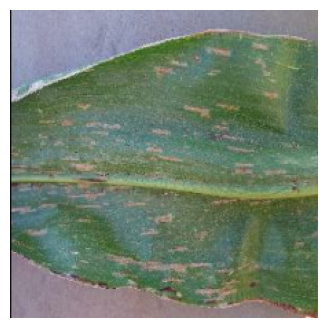

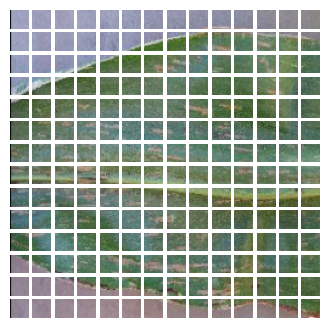

In [28]:
#Let's display patches for a sample image

plt.figure(figsize=(4, 4))
image = image_variable[0].numpy()
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

# patch encoding layer

In [29]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# ViT model

In [30]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train, and evaluate the model

In [17]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/ViT_model_selecting/Custome_ViT/models'

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1967s 12s/step - accuracy: 0.3910 - loss: 9.0644 - top-5-accuracy: 1.0000 - val_accuracy: 0.7087 - val_loss: 0.6553 - val_top-5-accuracy: 1.0000
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - accuracy: 0.5912 - loss: 0.9000 - top-5-accuracy: 1.0000 - val_accuracy: 0.7863 - val_loss: 0.5151 - val_top-5-accuracy: 1.0000
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 274ms/step - accuracy: 0.6976 - loss: 0.6448 - top-5-accuracy: 1.0000 - val_accuracy: 0.7601 - val_loss: 0.4663 - val_top-5-accuracy: 1.0000
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 87s 304ms/step - accuracy: 0.7609 - loss: 0.5704 - top-5-accuracy: 1.0000 - val_accuracy: 0.8792 - val_loss: 0.2909 - val_top-5-accuracy: 1.0000
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 280ms/step - accuracy: 0.8196 - loss: 0.4482 - top-5-accuracy: 1.0000 - val_accuracy: 0.8837 - val_loss: 0.3017 - val_top-5-accuracy: 1.0000
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.

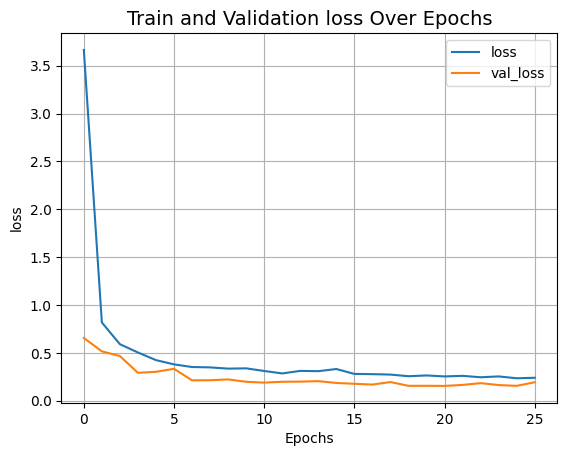

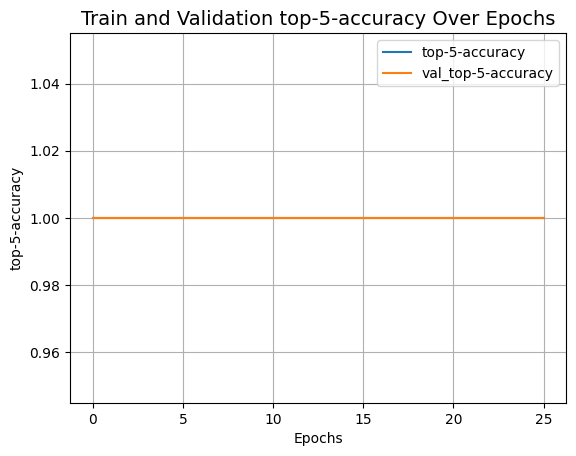

In [32]:
def run_experiment(model):
        optimizer = keras.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        checkpoint_filepath = "/tmp/checkpoint.weights.h5"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )

        early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

        history = model.fit(
            x=train_ds,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=validation_dataset,
            callbacks=[checkpoint_callback,early_stopping],
        )

        model.load_weights(checkpoint_filepath)

        #save the model
        tf.keras.models.save_model(model,model_path+'/corn-disease-classifier_vit.keras')

        _, accuracy, top_5_accuracy = model.evaluate(test_dataset)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")
        print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")



        return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")